In [21]:
import datetime as dt
import numpy as np 
import pandas as pd
import os
import requests

from math import log10, cos, sin, asin, sqrt, exp, pi, radians

def csvdate_to_date(x, dateformat):
    """Converts string x to a datetime.date using given format.

    :param x: the string representing a date
    :param dateformat: a strptime() accepted date format
    :return: a date
    """
    dt_f = dt.datetime.strptime(str(x), dateformat)
    dt_p = dt.datetime.strftime(dt_f, '%d.%m.%Y')
    return dt_p


# Conversion functions
def NoConversion(x, d):
    return float(x)


def kJ_to_MJ(x, d):
    return float(x)/1000.


def mm_to_cm(x, d):
    return float(x)/10.


def kPa_to_hPa(x, d):
    return float(x)*10.

class NASA_POWER:

    def __init__(self, latitude, longitude):
        if latitude < -90 or latitude > 90:
            msg = "Latitude should be between -90 and 90 degrees."
            raise ValueError(msg)
        if longitude < -180 or longitude > 180:
            msg = "Longitude should be between -180 and 180 degrees."
            raise ValueError(msg)

        self.MJ_to_J = lambda x: x * 1e6
        self.mm_to_cm = lambda x: x / 10.
        self.tdew_to_hpa = lambda x: ea_from_tdew(x) * 10.
        self.to_date = lambda d: d.date()
        self.HTTP_OK = 200
        self.angstA = 0.29
        self.angstB = 0.49

        self.latitude = latitude
        self.longitude = longitude

        self.power_variables = ["TOA_SW_DWN", "ALLSKY_SFC_SW_DWN", "T2M", "T2M_MIN",
                            "T2M_MAX", "T2MDEW", "WS2M", "PRECTOTCORR", 'RH2M']
        self._get_and_process_NASAPower(latitude, longitude)

    def _get_and_process_NASAPower(self, latitude, longitude):
            """Handles the retrieval and processing of the NASA Power data
            """
            powerdata = self._query_NASAPower_server(latitude, longitude)
            if not powerdata:
                msg = "Failure retrieving POWER data from server. This can be a connection problem with " \
                    "the NASA POWER server, retry again later."
                raise RuntimeError(msg)

            # Store the informational header then parse variables
            self.description = [powerdata["header"]["title"]]
            self.elevation = float(powerdata["geometry"]["coordinates"][2])
            
            
            df_power = self._process_POWER_records(powerdata)
#             self.angstA, self.angstB = self._estimate_AngstAB(df_power)
            weather_history = self._POWER_to_Pandas(df_power)
            self.weather_history = weather_history
            return weather_history
    def _query_NASAPower_server(self, latitude, longitude):
        start_date = dt.date(2010,1,1)
        end_date = dt.date.today()
        # build URL for retrieving data, using new NASA POWER api
        server = "https://power.larc.nasa.gov/api/temporal/daily/point"
        payload = {"request": "execute",
                    "parameters": ",".join(self.power_variables),
                    "latitude": latitude,
                    "longitude": longitude,
                    "start": start_date.strftime("%Y%m%d"),
                    "end": end_date.strftime("%Y%m%d"),
                    "community": "AG",
                    "format": "JSON",
                    "user": "anonymous"
                    }
        req = requests.get(server, params=payload)

        if req.status_code != self.HTTP_OK:
            msg = ("Failed retrieving POWER data, server returned HTTP " +
                    "code: %i on following URL %s") % (req.status_code, req.url)
            raise ValueError(msg)

        return req.json()

    def _process_POWER_records(self, powerdata):
        """Process the meteorological records returned by NASA POWER
        """


        fill_value = float(powerdata["header"]["fill_value"])

        df_power = {}
        for varname in self.power_variables:
            s = pd.Series(powerdata["properties"]["parameter"][varname])
            s[s == fill_value] = np.NaN
            df_power[varname] = s
        df_power = pd.DataFrame(df_power)
        df_power["DAY"] = pd.to_datetime(df_power.index, format="%Y%m%d")

        # find all rows with one or more missing values (NaN)
        ix = df_power.isnull().any(axis=1)
        # Get all rows without missing values
        df_power = df_power[~ix]

        return df_power
    
    def _POWER_to_Pandas(self, df_power):

            weather_history = pd.DataFrame({"date": df_power.DAY,#.apply(self.to_date),
                                    "tavg": df_power.T2M,
                                    "tmin": df_power.T2M_MIN,
                                    "tmax": df_power.T2M_MAX,
                                    "wind": df_power.WS2M,
                                    "globrad": df_power.ALLSKY_SFC_SW_DWN,
                                    "precip": df_power.PRECTOTCORR,
                                    "relhumid": df_power.RH2M})
            weather_history = weather_history.reset_index(drop=True)
            self.weather_history = weather_history
            return weather_history
        


def round_geoposition(x, prec=1, base=.5):
    return round(base * round(float(x)/base),prec)


In [28]:
weather = NASA_POWER(latitude = 34.138000, longitude = -118.125000)

In [29]:
df = weather.weather_history

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Mean temperature, °C')

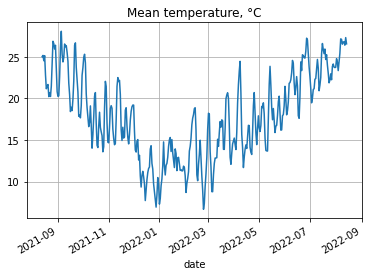

In [32]:
df.set_index('date')['tavg'][-365:].plot()
plt.grid()
plt.title('Mean temperature, °C')